In [1]:
! pip install -q langgraph langchain-community langchain-core langchain-google-genai faiss-cpu pypdf

# WorkFlow 1

In [2]:
from langgraph.graph import Graph

In [3]:
def function1(input1):
  return input1 + " from first function"

def function2(input2):
  return input2 + " from second function"

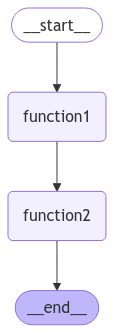

In [4]:
workflow1 = Graph()

workflow1.add_node("function1", function1)
workflow1.add_node("function2", function2)

workflow1.set_entry_point("function1")
workflow1.add_edge("function1", "function2")
workflow1.set_finish_point("function2")

graph = workflow1.compile()
graph

In [5]:
graph.invoke("Hi my name is saurav")

'Hi my name is saurav from first function from second function'

In [6]:
for output in graph.stream("Hi my name is saurav"):
  for key,value in output.items():
    print(f"{key}")
    print("---------")
    print(f"{value}")
    print("\n")

function1
---------
Hi my name is saurav from first function


function2
---------
Hi my name is saurav from first function from second function




In [7]:
def function1(input1):
  return input1 + " from first function"

def function2(input2):
  output = function3(" this is function 3 in betweem")
  return input2 + output +" from second function"

def function3(input3):
  return input3

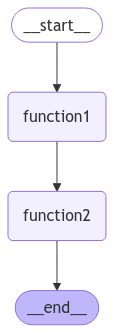

In [8]:
workflow1 = Graph()

workflow1.add_node("function1", function1)
workflow1.add_node("function2", function2)

workflow1.set_entry_point("function1")
workflow1.add_edge("function1", "function2")
workflow1.set_finish_point("function2")

graph = workflow1.compile()
graph

In [9]:
for output in graph.stream("Hi my name is saurav"):
  for key,value in output.items():
    print(f"{key}")
    print("---------")
    print(f"{value}")
    print("\n")

function1
---------
Hi my name is saurav from first function


function2
---------
Hi my name is saurav from first function this is function 3 in betweem from second function




# Workflow 2

In [10]:
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
import os
from google.colab import userdata

In [11]:
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [12]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
embedding = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [13]:
llm.invoke("Hi").content

'Hi there! How can I help you today?'

In [14]:
def function1(input1):
  llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
  response = llm.invoke(input1)
  return response.content

def function2(input2):
  return input2.upper()

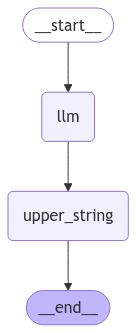

In [15]:
workflow2 = Graph()


workflow2.add_node("llm", function1)
workflow2.add_node("upper_string", function2)

workflow2.set_entry_point("llm")
workflow2.add_edge("llm", "upper_string")
workflow2.set_finish_point("upper_string")

graph = workflow2.compile()
graph

In [16]:
graph.invoke("Hi")

'HI THERE! HOW CAN I HELP YOU TODAY?'

In [17]:
for output in graph.stream("Hi"):
  for key,value in output.items():
    print(f"{key}")
    print("---------")
    print(f"{value}")
    print("\n")

llm
---------
Hi there! How can I help you today?


upper_string
---------
HI THERE! HOW CAN I HELP YOU TODAY?




# Workflow 3

In [18]:
def function1(input1):
  llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
  response = llm.invoke(input1)
  return response.content

def function2(input2):
  return input2.upper()

def function3(input1):
  token = input1.split()
  token_number = len(token)
  return token_number

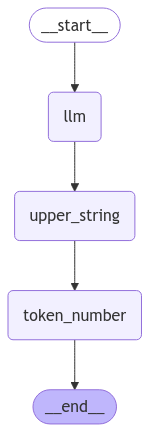

In [19]:
workflow3 = Graph()

workflow3.add_node("llm",function1)
workflow3.add_node("upper_string", function2)
workflow3.add_node("token_number", function3)

workflow3.set_entry_point("llm")
workflow3.add_edge("llm", "upper_string")
workflow3.add_edge("upper_string", "token_number")
workflow3.set_finish_point("token_number")

graph = workflow3.compile()
graph

In [20]:
graph.invoke("Hi")

8

In [21]:
for output in graph.stream("Hi"):
  for key,value in output.items():
    print(f"{key}")
    print("---------")
    print(f"{value}")
    print("\n")

llm
---------
Hi there! How can I help you today?


upper_string
---------
HI THERE! HOW CAN I HELP YOU TODAY?


token_number
---------
8




# Workflow 4

In [22]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
embedding = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [23]:
llm.invoke("hello").content

'Hello there! How can I help you today?'

In [24]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [25]:
loader = PyPDFLoader("transformers.pdf")
data = loader.load()

In [26]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

chunks = text_splitter.split_documents(data)

In [27]:
db = FAISS.from_documents(chunks,embedding)
db

In [28]:
retriever = db.as_retriever()
retriever

VectorStoreRetriever(tags=['FAISS', 'GoogleGenerativeAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7cbac81a4a90>, search_kwargs={})

In [29]:
def function1(AgentState):

  message = AgentState["messages"]

  question = message[-1]

  complete_prompt = f"""
  Your task is to provide only the brief answer based on the user query.
  Question: {question}
  """

  response = llm.invoke(complete_prompt)

  AgentState["messages"].append(response.content)

  return AgentState

In [30]:
def function2(AgentState):

  messages = AgentState["messages"]
  question = messages[0]

  template = '''
  Answer the question based on the following context:
  {context}
  Question: {question}
  '''
  prompt = ChatPromptTemplate.from_template(template)

  chain = (
      {"context": retriever , "question":RunnablePassthrough()}
      | prompt
      | llm
      | StrOutputParser()
  )

  result = chain.invoke(question)
  return result

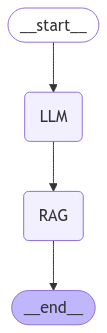

In [31]:
workflow4 = Graph()
workflow4.add_node("LLM",function1)
workflow4.add_node("RAG",function2)

workflow4.set_entry_point("LLM")
workflow4.add_edge("LLM","RAG")
workflow4.set_finish_point("RAG")

graph = workflow4.compile()
graph

In [32]:
graph.invoke({"messages":["What is transformers"]})

"Based on the provided text, the Transformer is a new, simple network architecture for sequence transduction.  It's based solely on attention mechanisms, eliminating the need for recurrence and convolutions.  This makes it superior in quality, more parallelizable, and significantly faster to train than models using recurrent or convolutional layers.  The Transformer achieves state-of-the-art results on machine translation tasks (English-to-German and English-to-French) and also performs well on English constituency parsing."

# Workflow 5

In [33]:
from langgraph.graph import StateGraph, START, END, add_messages
from typing_extensions import TypedDict, Annotated
from pydantic import BaseModel, Field

In [34]:
class AgentState(TypedDict):
  messages: Annotated[list,add_messages]

In [35]:
class TopicSelectionParser(BaseModel):
  topic: str = Field(description="The topic selected by the user")
  Reasoning:str = Field(description="Reasoning for selecting the topic")

In [36]:
def function1(state:AgentState):

  message = state["messages"]
  question = message[-1]
  print(question)

  template = '''
  Your task is to classify given question into one of following categories: [Transformers,Not Related].
  Only respond with the category name and nothing else.

  Question: {question}
  '''

  prompt = ChatPromptTemplate.from_template(template)

  chain = prompt | llm | StrOutputParser()

  response = chain.invoke({"question":question})

  print(response,"1")

  return {"messages":response}

In [37]:
state = {"messages":["Tell me about transformers"]}
function1(state)

Tell me about transformers
Transformers 1


{'messages': 'Transformers'}

In [38]:
def router(state:AgentState):
  print("Router--->")
  messages = state["messages"]
  last_messages = messages[-1]
  print(last_messages.content,"2")
  if "Transformers" in last_messages:
    return "RAG Call"
  else:
    return "LLM Call"

In [39]:
def function2(state:AgentState):
  print("Calling RAG--->")
  messages = state["messages"]
  question = messages[0]
  print(question)

  template = '''
  Answer the question based on the following context:
  {context}
  Question: {question}
  '''
  prompt = ChatPromptTemplate.from_template(template)

  chain = (
      {"context": retriever , "question":RunnablePassthrough()}
      | prompt
      | llm
      | StrOutputParser()
  )

  result = chain.invoke(question)
  return {"messages":[result]}

In [40]:
def function3(state:AgentState):
  print("Calling LLM--->")
  messages = state["messages"]
  question = messages[0]

  complete_query = f"Answer the following question briefly {question}"
  response = llm.invoke(complete_query)
  return {"messages": [response.content]}


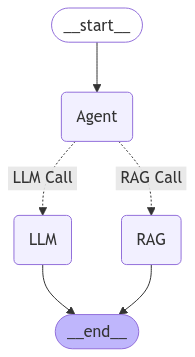

In [41]:
workflow5 = StateGraph(AgentState)

workflow5.add_node("Agent",function1)
workflow5.add_node("RAG",function2)
workflow5.add_node("LLM",function3)

workflow5.add_edge(START,"Agent")
workflow5.add_conditional_edges("Agent",
                                router,
                                {
                                    "RAG Call":"RAG",
                                    "LLM Call":"LLM"
                                })
workflow5.add_edge("RAG",END)
workflow5.add_edge("LLM",END)

graph = workflow5.compile()
graph

In [42]:
output = graph.invoke({"messages":["What is Transformers"]})
print(output)

content='What is Transformers' additional_kwargs={} response_metadata={} id='89efeb46-bab0-459a-ac9f-54c4464d4865'
Transformers 1
Router--->
Transformers 2
Calling LLM--->
{'messages': [HumanMessage(content='What is Transformers', additional_kwargs={}, response_metadata={}, id='89efeb46-bab0-459a-ac9f-54c4464d4865'), HumanMessage(content='Transformers', additional_kwargs={}, response_metadata={}, id='2b132048-07f0-424c-a08b-b9eb179bcde3'), HumanMessage(content='Transformers are a type of neural network architecture, primarily used in natural language processing (NLP), that leverage self-attention mechanisms to process sequential data.', additional_kwargs={}, response_metadata={}, id='f526d2b7-027d-4c3b-9fef-f1278f914946')]}
